In [2]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Activation, Input, concatenate, BatchNormalization 
from keras.layers import Conv3D, UpSampling3D, Conv3DTranspose, MaxPooling3D,AveragePooling3D,GlobalAveragePooling3D, MaxPooling2D, GlobalAveragePooling2D, Conv2D
from keras.layers import add
from keras.layers import LeakyReLU, Reshape, Lambda
from keras.initializers import RandomNormal
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow import keras
import numpy as np
import os 

Init Plugin
Init Graph Optimizer
Init Kernel


## 3D CNN 

In [3]:

def myConv3D(x_in, nf, strides=1, kernel_size = 3):
    """
    specific convolution module including convolution followed by leakyrelu
    """
    x_out = Conv3D(nf, kernel_size=3, padding='same',kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = BatchNormalization()(x_out)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out


def S3D_CNN(vol_size):
    print(vol_size)
    inputs = Input(shape=vol_size)
    layer = myConv3D(inputs, nf = 32)  
    layer = MaxPooling3D(pool_size= (3,3,3),strides=2)(layer)
    layer = myConv3D(layer, nf =128)
    layer = MaxPooling3D(pool_size= (3,3,3),strides=2)(layer)  
    layer = myConv3D(layer, nf= 256)
    layer = MaxPooling3D(pool_size= (3,3,3),strides=2)(layer) 
    layer = myConv3D(layer, nf= 512)
    layer = MaxPooling3D(pool_size= (5,5,5),strides=2)(layer)
    layer = GlobalAveragePooling3D()(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(128, activation='relu')(layer)
    layer = Dense(64, activation='relu')(layer)
    x = Dense(1,activation="sigmoid")(layer)
    #x = Activation('sigmoid')(layer)
   # x = Activation('softmax', name='softmax')(layer)
        
    model = Model(inputs=[inputs], outputs=[x])
    return model


In [4]:
S3DCNNModel = S3D_CNN((128,128,128,1))
S3DCNNModel.summary()

(128, 128, 128, 1)
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 128, 1) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 128, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128, 32) 128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 128, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 63, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 63, 63, 63, 128)   110720    
_______________________________

2023-03-24 17:35:56.853870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-24 17:35:56.853991: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_val = np.load("x_val.npy")
y_val = np.load("y_val.npy")
x_test = np.load("x_test.npy")
y_test =np.load("y_test.npy")

# Augumenting Data

In [6]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    #volume = rotate(volume)
    return volume, label


def test_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    return volume, label


In [7]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 4
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
test_dataset = (
    test_loader.shuffle(len(x_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [8]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
S3DCNNModel.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "S3D_CNN.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
S3DCNNModel.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)
    

KeyboardInterrupt: 

In [ ]:
# Load best weights.
S3DCNNModel.load_weights("S3D_CNN.h5")
prediction = S3DCNNModel.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["CN", "AD"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 6.86 percent confident that CT scan is CN
This model is 93.14 percent confident that CT scan is AD


In [ ]:
preds_test = []
for i in range(0, len(x_test)):
    preds_test.append(S3DCNNModel.predict(np.expand_dims(x_test[i], axis=0))[0][0])


In [ ]:
predictionlist = [1 if x>0.5 else 0 for x in preds_test]

In [ ]:
groundtruthlist = y_test.tolist()

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(groundtruthlist, predictionlist)

Confusion matrix, without normalization
[[31  0]
 [ 9 12]]


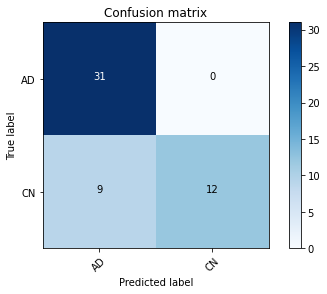

In [ ]:
plot_confusion_matrix(cm,classes=["AD","CN"])

In [ ]:
from sklearn.metrics import f1_score, precision_score,recall_score
print(f1_score(groundtruthlist, predictionlist, average='macro'))
print(precision_score(groundtruthlist, predictionlist,pos_label=1))
print(precision_score(groundtruthlist, predictionlist,pos_label=0))
print(recall_score(groundtruthlist, predictionlist,pos_label=1))
print(recall_score(groundtruthlist, predictionlist,pos_label=0))

0.8002560819462228
1.0
0.775
0.5714285714285714
1.0


## 2D MultiView Slice CNN

(5, 128, 128, 1)


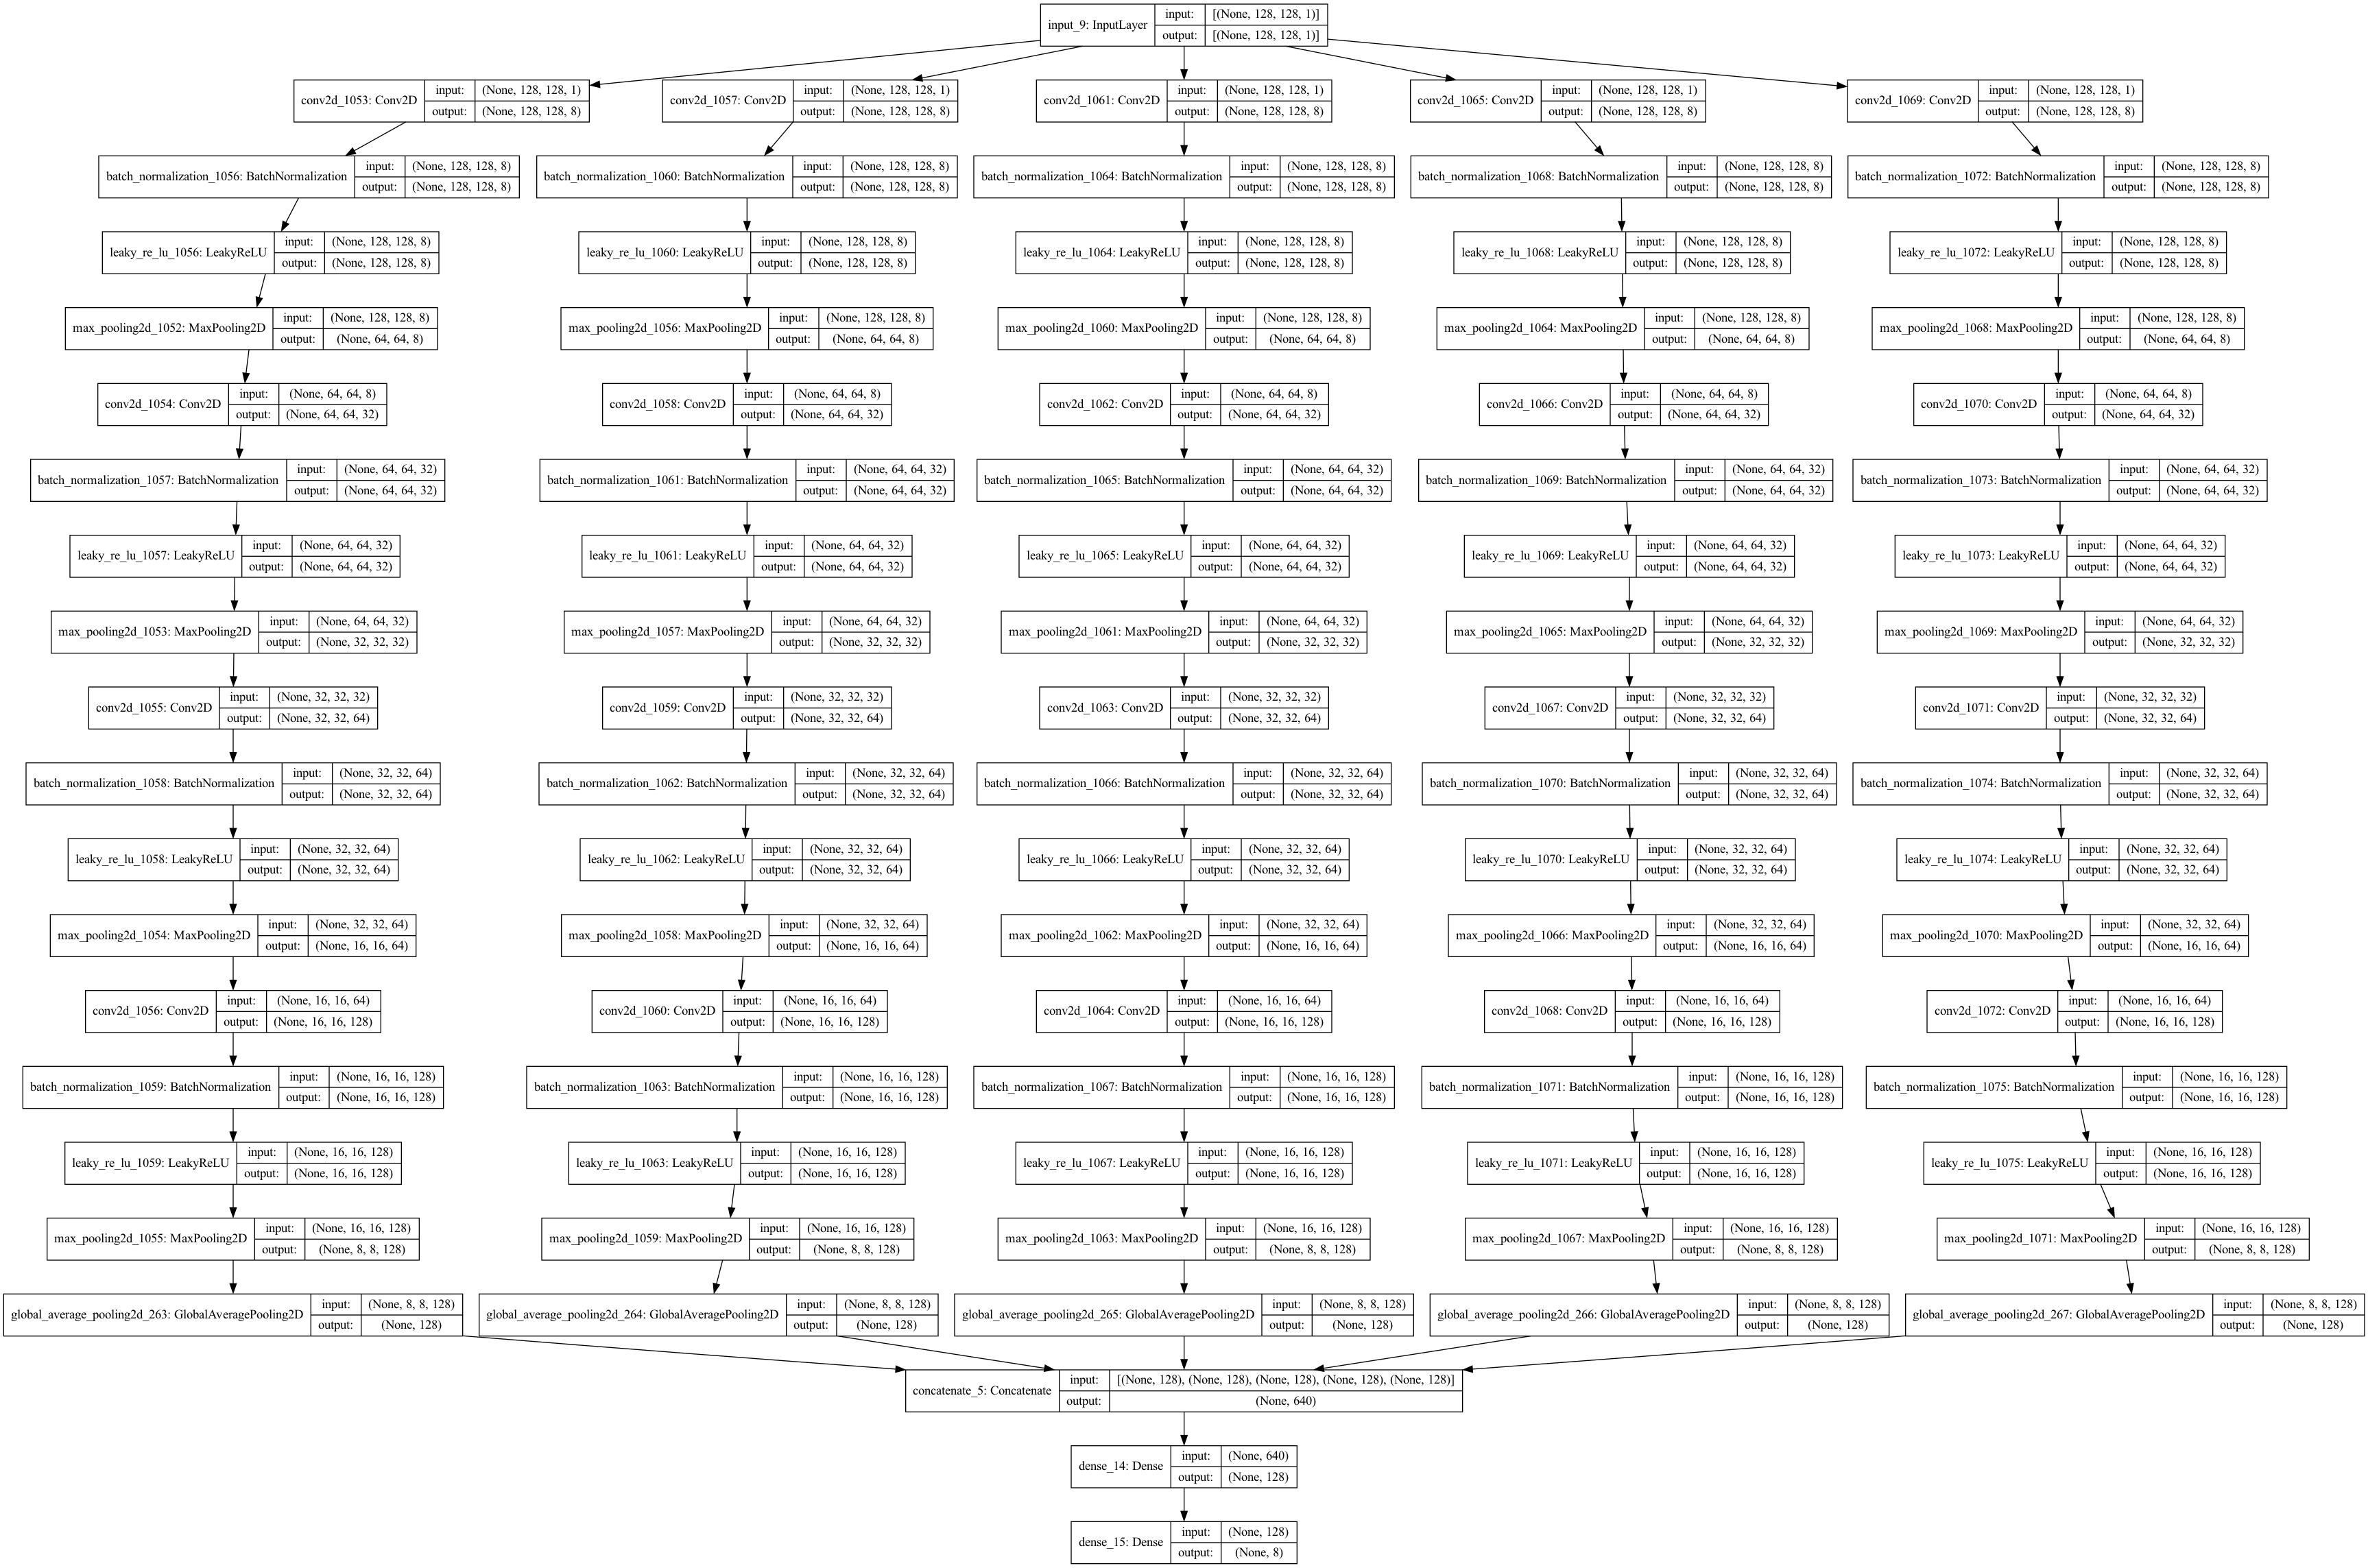

In [15]:

def myConv2DBlock(x_in, nf, strides=1, kernel_size = 3):
    """
    specific convolution module including convolution followed by leakyrelu
    """
    x_out = Conv2D(nf, kernel_size=3, padding='same',kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = BatchNormalization()(x_out)
    x_out = LeakyReLU(0.2)(x_out)
    x_out = MaxPooling2D(pool_size= (2,2),strides=2)(x_out)
    return x_out

# it looks like we will have many Slice level sub-networks so we can easily use a for loop to create as many as needed using this function
def S2D_CNN_SLICE_SUB_NETWORK(inputs):
    layer = myConv2DBlock(inputs, nf = 8)  
    layer = myConv2DBlock(layer, nf = 32)
    layer = myConv2DBlock(layer, nf = 64)
    layer = myConv2DBlock(layer, nf = 128)
    layer = GlobalAveragePooling2D()(layer)
        
    return layer

# lets make a function to create the Slice level sub-networks and then concatenate them
def S2D_CNN_NETWORK(vol_size):
    print(vol_size)
    num_slices = vol_size[0]
    inputs = Input(shape=vol_size[1:])
    slice_networks = []
    for i in range(num_slices):
        slice_networks.append(S2D_CNN_SLICE_SUB_NETWORK(inputs))
    layer = concatenate(slice_networks)
    layer = Dense(128, activation='relu')(layer)
    layer = Dense(8, activation='relu')(layer)
    model = Model(inputs=[inputs], outputs=[layer])
    

    return model

testModel = S2D_CNN_NETWORK((5,128,128,1))
keras.utils.plot_model(testModel, show_shapes=True)